# Capstone Project
This notebook will be used to complete the capstone project for "Applied Data Science Capstone."

In [1]:
import pandas as pd
import numpy as np
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


In [2]:
#More imports needed for later in the notebook:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.neighbors import KNeighborsClassifier

## Introduction
The ability to judge the likelihood of a severe traffic accident given the weather and road conditions has a number of useful applications. One potential use of this information would be warning drivers of unsafe driving conditions on their route. Another might be automatic recommendation of speed limit adjustments on roads where this is possible. This project seeks to use machine learning to determine if weather and road conditions can be used to predict the likelihood of increased accident severity.

## Data
This project will use a data set of traffic collisions recorded by the Seattle Police Department and Traffic Records (the data set provided by the course). This data set provides a set of descriptive features of each collision, as well as the environment where each collision occured, such as weather and road conditions. The data is labeled with a number from 0 to 3 indicating the severity of each collision. To predict whether a collision that occurs has a high probability of being severe, I will use the environmental features of this data set as well as the severity labels to train a machine learning model.

## Methodology
The first stage of building a model to predict collision severity is preparation of the data.

In [3]:
#Read in the data and take a brief look
#df = pd.read_csv('https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv')
df = pd.read_csv('Data-Collisions.csv')
df.head()

C:\Users\Joel\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


Because we want to be able to predict increased risk of accident severity, we should only use features that could be determined before an accident occurs. Many of the columns in the dataset are descriptions of an accident that has already occured, and are therefore inappropriate to use in this study. Looking at the columns, the only features that can be determined before a collision occurs are the type of address (ADDRTYPE), the weather (WEATHER), the conditions of the road (ROADCOND), the lighting conditions (LIGHTCOND), whether a vehicle is going above the speed limit (SPEEDING). However, it's worth noting that the SPEEDING category has a large number of null entries, as shown with the code below. For this reason, the SPEEDING column will not be used as a feature.

In [4]:
df['SPEEDING'].isnull().value_counts()

True     185340
False      9333
Name: SPEEDING, dtype: int64

After trimming out all of the features that can't be determined until after the collision occurs, we still have to deal with missing data. In this case, any row that has a null value in any column is dropped. This option was chosen because only a relatively small number of entries contain a null value.

In [5]:
#First, let's trim out all of the columns that we won't be using. For this, let's only keep: SEVERITYCODE, ADDRTYPE, WEATHER, ROADCOND, LIGHTCOND
df_2 = df[['SEVERITYCODE', 'ADDRTYPE','WEATHER','ROADCOND','LIGHTCOND']]
print(df_2.shape)

#Some rows have null values in some fields. Let's drop any row that contains a null value
df_2.dropna(0,inplace=True)
print(df_2.shape)


(194673, 5)
(187525, 5)


<ipython-input-5-463c5a0e3d52>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2.dropna(0,inplace=True)


Now that the null values have been removed, it's still good to check what values exist in each column.

In [6]:
#Let's make sure the other values make senes
print(df_2['ADDRTYPE'].value_counts())
print(df_2['WEATHER'].value_counts())
print(df_2['ROADCOND'].value_counts())
print(df_2['LIGHTCOND'].value_counts())

Block           123321
Intersection     63462
Alley              742
Name: ADDRTYPE, dtype: int64
Clear                       110499
Raining                      32976
Overcast                     27551
Unknown                      14059
Snowing                        896
Other                          790
Fog/Smog/Smoke                 563
Sleet/Hail/Freezing Rain       112
Blowing Sand/Dirt               49
Severe Crosswind                25
Partly Cloudy                    5
Name: WEATHER, dtype: int64
Dry               123736
Wet                47223
Unknown            14009
Ice                 1193
Snow/Slush           992
Other                124
Standing Water       111
Sand/Mud/Dirt         73
Oil                   64
Name: ROADCOND, dtype: int64
Daylight                    115408
Dark - Street Lights On      48236
Unknown                      12599
Dusk                          5843
Dawn                          2491
Dark - No Street Lights       1526
Dark - Street Lights Off 

Notice that many columns have possible values of "Unknown" or "Other," which will not be useful for our purposes. The code below removes rows that contain values such as these. Fortunately, these types of entries are rare, and we still retain the vast majority of our dataset.

In [7]:
#Also eliminate rows of the dataframe that contain unknown values. We'll notice that the dataframe still retains over 160,000 entries
keepWEATHER = ~((df_2['WEATHER'] == 'Unknown') | (df_2['WEATHER'] == 'Other'))
keepROADCOND = ~((df_2['ROADCOND'] == 'Unknown') | (df_2['ROADCOND'] == 'Other'))
keepLIGHTCOND = ~((df_2['LIGHTCOND'] == 'Unknown') | (df_2['LIGHTCOND'] == 'Other') | (df_2['LIGHTCOND'] == 'Dark - Unknown Lighting'))
keep = keepWEATHER & keepROADCOND & keepLIGHTCOND
df_2 = df_2[keep]
df_2.shape

(169239, 5)

Since all of the features we are using in our data set are categorical (and thus not conducive to training some models), I convert all of our features into logical columns, where each possible value for a feature is its own column, and a 1 indicates that that collision had that value in the original feature column.

In [29]:
#As all of our features are categorical, let's turn them into dummy integer variables.
df_3 = pd.get_dummies(df_2)
df_3.head()

,SEVERITYCODE,ADDRTYPE_Alley,ADDRTYPE_Block,ADDRTYPE_Intersection,WEATHER_Blowing Sand/Dirt,WEATHER_Clear,WEATHER_Fog/Smog/Smoke,WEATHER_Overcast,WEATHER_Partly Cloudy,WEATHER_Raining,...,ROADCOND_Sand/Mud/Dirt,ROADCOND_Snow/Slush,ROADCOND_Standing Water,ROADCOND_Wet,LIGHTCOND_Dark - No Street Lights,LIGHTCOND_Dark - Street Lights Off,LIGHTCOND_Dark - Street Lights On,LIGHTCOND_Dawn,LIGHTCOND_Daylight,LIGHTCOND_Dusk
0,2,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
1,1,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
2,1,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,2,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0


The last step of data preparation is to adjust the values in the SEVERITYCODE column (the target). Because the only entries we have are 1 or 2, for simplicity I relabel them as 0 or 1, with 0 indicating collisions that are not severe, and 1 indicating a more severe collision.

In [30]:
#Finally, since we only have 1's and 2's in the SEVERITYCODE column, let's relabel so that 1 becomes 0 (not severe)
#and anything greater than 1 becomes 1 (severe)
df_3['SEVERITYCODE'] = df_3['SEVERITYCODE']-1

Before testing a model, split the data into training and testing sets.

In [31]:
X_train, X_test, y_train, y_test = train_test_split( df_3.drop('SEVERITYCODE',axis=1), \
                                                    df_3[['SEVERITYCODE']], test_size=0.2, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(135391, 25) (135391, 1)
(33848, 25) (33848, 1)


Now we're ready to select and train a model. Since our data is labeled, we use a supervised model. Because the target is a categorical variable and because we want to calculate a probability of an accident being severe, logistic regression seems like a good place to start.

Max Jaccard score of  0.45115622924568377  for C =  0.06599059954035558


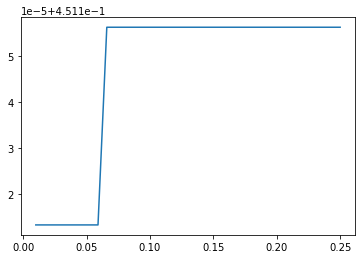

In [32]:
#Initialize an array of regularization values to try
Carray = np.geomspace(0.01,0.25,30) #parameters are: Starting C, Ending C, number of C's to try

#Initialize array to hold Jaccard similarity scores to evaluate the model
Jarray = np.zeros(len(Carray))

#Loop over the c values to try
for i,c in enumerate(Carray):
    LR = LogisticRegression(C=c, solver = 'liblinear').fit(X_train,y_train.values.ravel())
    yhat = LR.predict(X_test)
    Jarray[i] = jaccard_score(y_test,yhat,average='weighted')
    
#Print out which C value gave the best Jaccard similarity score
print('Max Jaccard score of ', Jarray.max(), ' for C = ', Carray[Jarray.argmax()])

#Plot Jaccard score relative to regularization
plt.plot(Carray,Jarray)

In [33]:
#Try computing F1 score of best LR model
LR = LogisticRegression(C=Carray[Jarray.argmax()], solver = 'liblinear').fit(X_train,y_train.values.ravel())
yhat = LR.predict(X_test)
print(precision_score(y_test,yhat))
print(recall_score(y_test,yhat))
print(f1_score(y_test,yhat,average='weighted'))
print(yhat.sum())

1.0
8.997660608241857e-05
0.5397909683679565
1


It appears that a Logistic Regression model is quite poor at predicting whether certain conditions will lead to more severe accidents. In particular, this model seems to be underfitting the data, as it only predicts severe accidents for one case in the test set. At this stage, it's worth taking a look at a different model, for example a K-nearest-neighbors model.

Done testing k =  1
Done testing k =  2
Done testing k =  3
Done testing k =  4
Done testing k =  5
Done testing k =  6
Done testing k =  7
Max Jaccard score of  0.23302059361538915  for k =  1


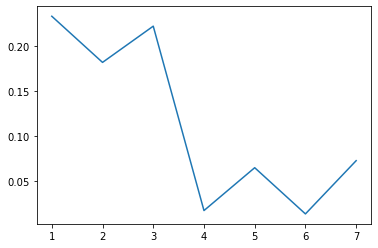

In [49]:
#CODE BELOW TAKES A VERY LONG TIME TO RUN. 

##Try a KNN algorithm instead. While this won't give a probability, it will be able to classify new cases
#
##Initialize an array of number of neighbors to try
#karray = np.array(list(range(1,8)))
#
##Initialize array to hold Jaccard similarity scores to evaluate the model
#Jarray = np.zeros(len(karray))
#
##Loop over the c values to try
#for i,k in enumerate(karray):
#    knn = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train.values.ravel())
#    yhat = knn.predict(X_test)
#    Jarray[i] = jaccard_score(y_test,yhat)
#    print("Done testing k = ", k)
#    
##Print out which C value gave the best Jaccard similarity score
#print('Max Jaccard score of ', Jarray.max(), ' for k = ', karray[Jarray.argmax()])
#
##Plot Jaccard score relative to regularization
#plt.plot(karray,Jarray)

The KNN model seems to do somewhat better than the logistic regression model. Let's take a look at precision, recall, and F1 score.

In [34]:
knn = KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train.values.ravel())
yhat = knn.predict(X_test)
print(precision_score(y_test,yhat))
print(recall_score(y_test,yhat))
print(f1_score(y_test,yhat,average='weighted'))
yhat.sum() #How many times did the algorithm predict severe collisions?

0.40370067470864857
0.35531761741947093
0.6092146540545096


9782

The K-Nearest-Neighbors classification model performed much better than the logistic regression one. However, both of the models we've tested seem to perform rather poorly with the data. It's worth going back and investigating the individual relationships between each feature and the target variable. We do this by plotting histograms.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027539507D00>,
      dtype=object)

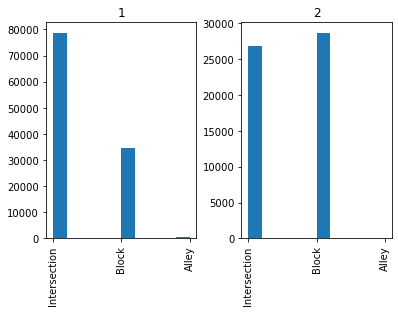

In [35]:
df_2.hist(column = 'ADDRTYPE', by = 'SEVERITYCODE',sharex=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027539BED640>,
      dtype=object)

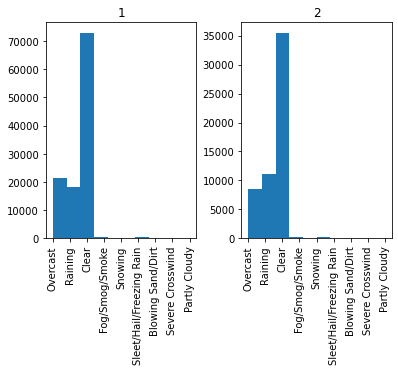

In [36]:
df_2.hist(column = 'WEATHER', by = 'SEVERITYCODE',sharex=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027539AD1880>,
      dtype=object)

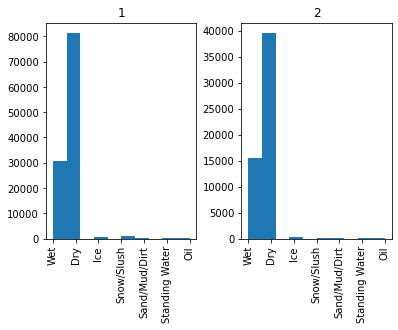

In [37]:
df_2.hist(column = 'ROADCOND', by = 'SEVERITYCODE',sharex=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027539C4A4F0>,
      dtype=object)

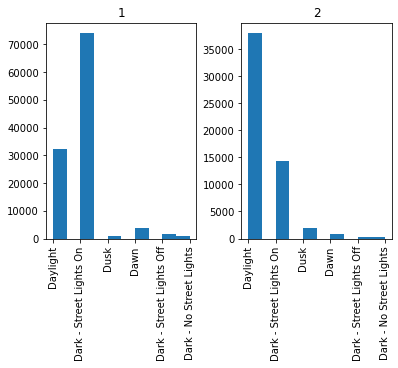

In [38]:
df_2.hist(column = 'LIGHTCOND', by = 'SEVERITYCODE',sharex=True)

As can be seen above, both types of collisions have very similar distributions for each feature, with the exception of lighting condition. This can be seen as the relative size of the bars in each of the first three pairs of histograms is quite similar. Based on this, it is little surprise that this data alone was not able to accurately predict the severity of collisions.

## Results

A logistic regression model was trained on the data. The optimal choice of regularization parameter was approximately 0.065. however, the Jaccard similarity score for this model was only about 0.00009. The logistic regression model predicted less severe collisions for almost every case - a result of underfitting. 
Given the lackluster performance of a logistic regression model, a K-Nearest-Neighbors model was selected. This model performed better, with a Jaccard similarity score of 0.23 and a weighter F1 score of 0.6, however, this is still a somewhat poor predicter of collision severity.

## Discussion

The results of both models chosen to predict collision severity are not encouraging, as both failed to make accurate predictions. One likely explanation for this is the similar distribution of each feature among the different target cases. No single feature is a good predictor of collision severity for this reason, and the results from the machine learning models indicate that few (if any) combinations of them are good predictors.

## Conclusion

A data set describing a set of traffic collisions in the Seattle area was cleaned and analyzed to see if it could be used to make predictions as to the likelihood of severe collisions occuring. After trying two separate machine learning models (Logistic Regression and K-Nearest-Neighbors), it was determined that the features available in this data set are not good predictors of collision severity.